# MALICIOUS WEB DETECTION WITH 1D CNN (Convolution Neural Network)

In [1]:
!pip install tldextract

In [2]:
!pip install tensorflow --user

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import gc
import random
import os
import pickle
import tldextract
from urllib.parse import urlparse
import tensorflow as tf
from tensorflow.python.util import deprecation


In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers, backend, metrics
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# set random seed
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.random.seed(0)
random.seed(0)
#tf.set_random_seed(0)

In [6]:
# other setup
%config InlineBackend.figure_format = 'retina'
pd.set_option('max_colwidth', 500)
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Loading Data

In [7]:
# load data
data = pd.read_csv('./malicious_url_dataset.csv')
# shuffle data
data = data.sample(frac=1, random_state=0)
print(f'Data size: {data.shape}')
data.head()

Data size: (420464, 2)


,url,label
36210,a.kafunews.com/wp-includes/certificates/webmail.ccri.edu.html,bad
77403,en.wikipedia.org/wiki/Claude_Lemieux,good
390133,www.jklgdf789dh43.com/7890890778yer/rtrtyr/rty/rty/ery/er.php?id=,bad
356113,trulia.com/LA/New_Orleans/70115/,good
260369,ibikedb.net/bikes/27862-ccm-supercycle-thrill,good


* Here we use the holdout method for validation method which separates training and test data by 80% and 20%

In [8]:
val_size = 0.2
train_data, val_data = train_test_split(data, test_size=val_size, stratify=data['label'], random_state=0)
print(f'Train shape: {train_data.shape}, Validation shape: {val_data.shape}')
# Train 70% Validation 10%, testing 20%

Train shape: (336371, 2), Validation shape: (84093, 2)


# Data Analysis and Feature Engineering
We perform some data analysis to expand our knowledge of this data and do some feature engineering. First we want to find out whether the data is imbalance

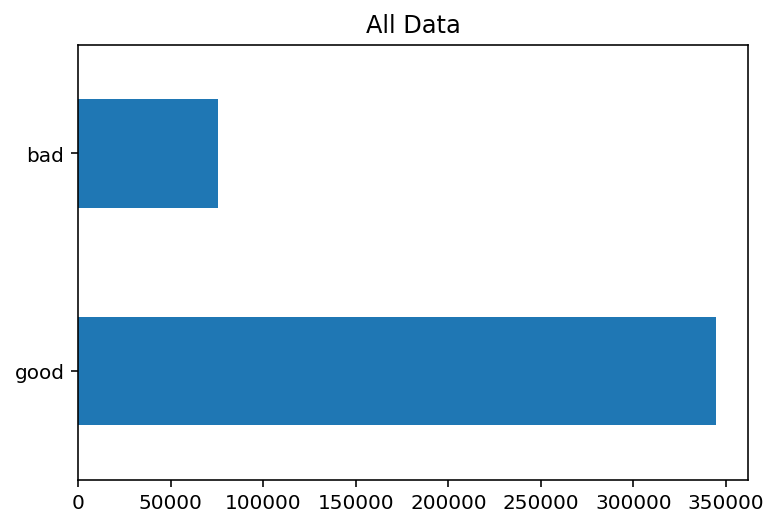

In [9]:
data.label.value_counts().plot.barh()
plt.title('All Data')
plt.show()

In [10]:
good, bad = data.label.value_counts()
print(f'Ratio of data between target labels (bad & good) is {bad//bad}:{good//bad}')

Ratio of data between target labels (bad & good) is 1:4


Next, lets find out the most used suffix domain, domain and sub domain. We need to extract subdomains, domains and domain suffixes to be able to do the analysis

In [11]:
def parsed_url(url):
    # extract subdomain, domain, and domain suffix from url
    # if item == '', fill with '<empty>'
    subdomain, domain, domain_suffix = ('<empty>' if extracted == '' else extracted for extracted in tldextract.extract(url))
    return [subdomain, domain, domain_suffix]

In [12]:
def extract_url(data):
    # parsed url
    extract_url_data = [parsed_url(url) for url in data['url']]
    extract_url_data = pd.DataFrame(extract_url_data, columns=['subdomain', 'domain', 'domain_suffix'])
    # concat extracted feature with main data
    data = data.reset_index(drop=True)
    data = pd.concat([data, extract_url_data], axis=1)
    return data

In [13]:
train_data = extract_url(train_data)
val_data = extract_url(val_data)

In [14]:
def plot(train_data, val_data, column):
    plt.figure(figsize=(10, 17))
    plt.subplot(411)
    plt.title(f'Train data {column}')
    plt.ylabel(column)
    train_data[column].value_counts().head(10).plot.barh()
    plt.subplot(412)
    plt.title(f'Validation data {column}')
    plt.ylabel(column)
    val_data[column].value_counts().head(10).plot.barh()
    plt.subplot(413)
    plt.title(f'Train data {column} (groupped)')
    plt.ylabel(f'(label, {column})')
    train_data.groupby('label')[column].value_counts().head(10).plot.barh()
    plt.subplot(414)
    plt.title(f'Validation data {column} (groupped)')
    plt.ylabel(f'(label, {column})')
    val_data.groupby('label')[column].value_counts().head(10).plot.barh()
    plt.show()

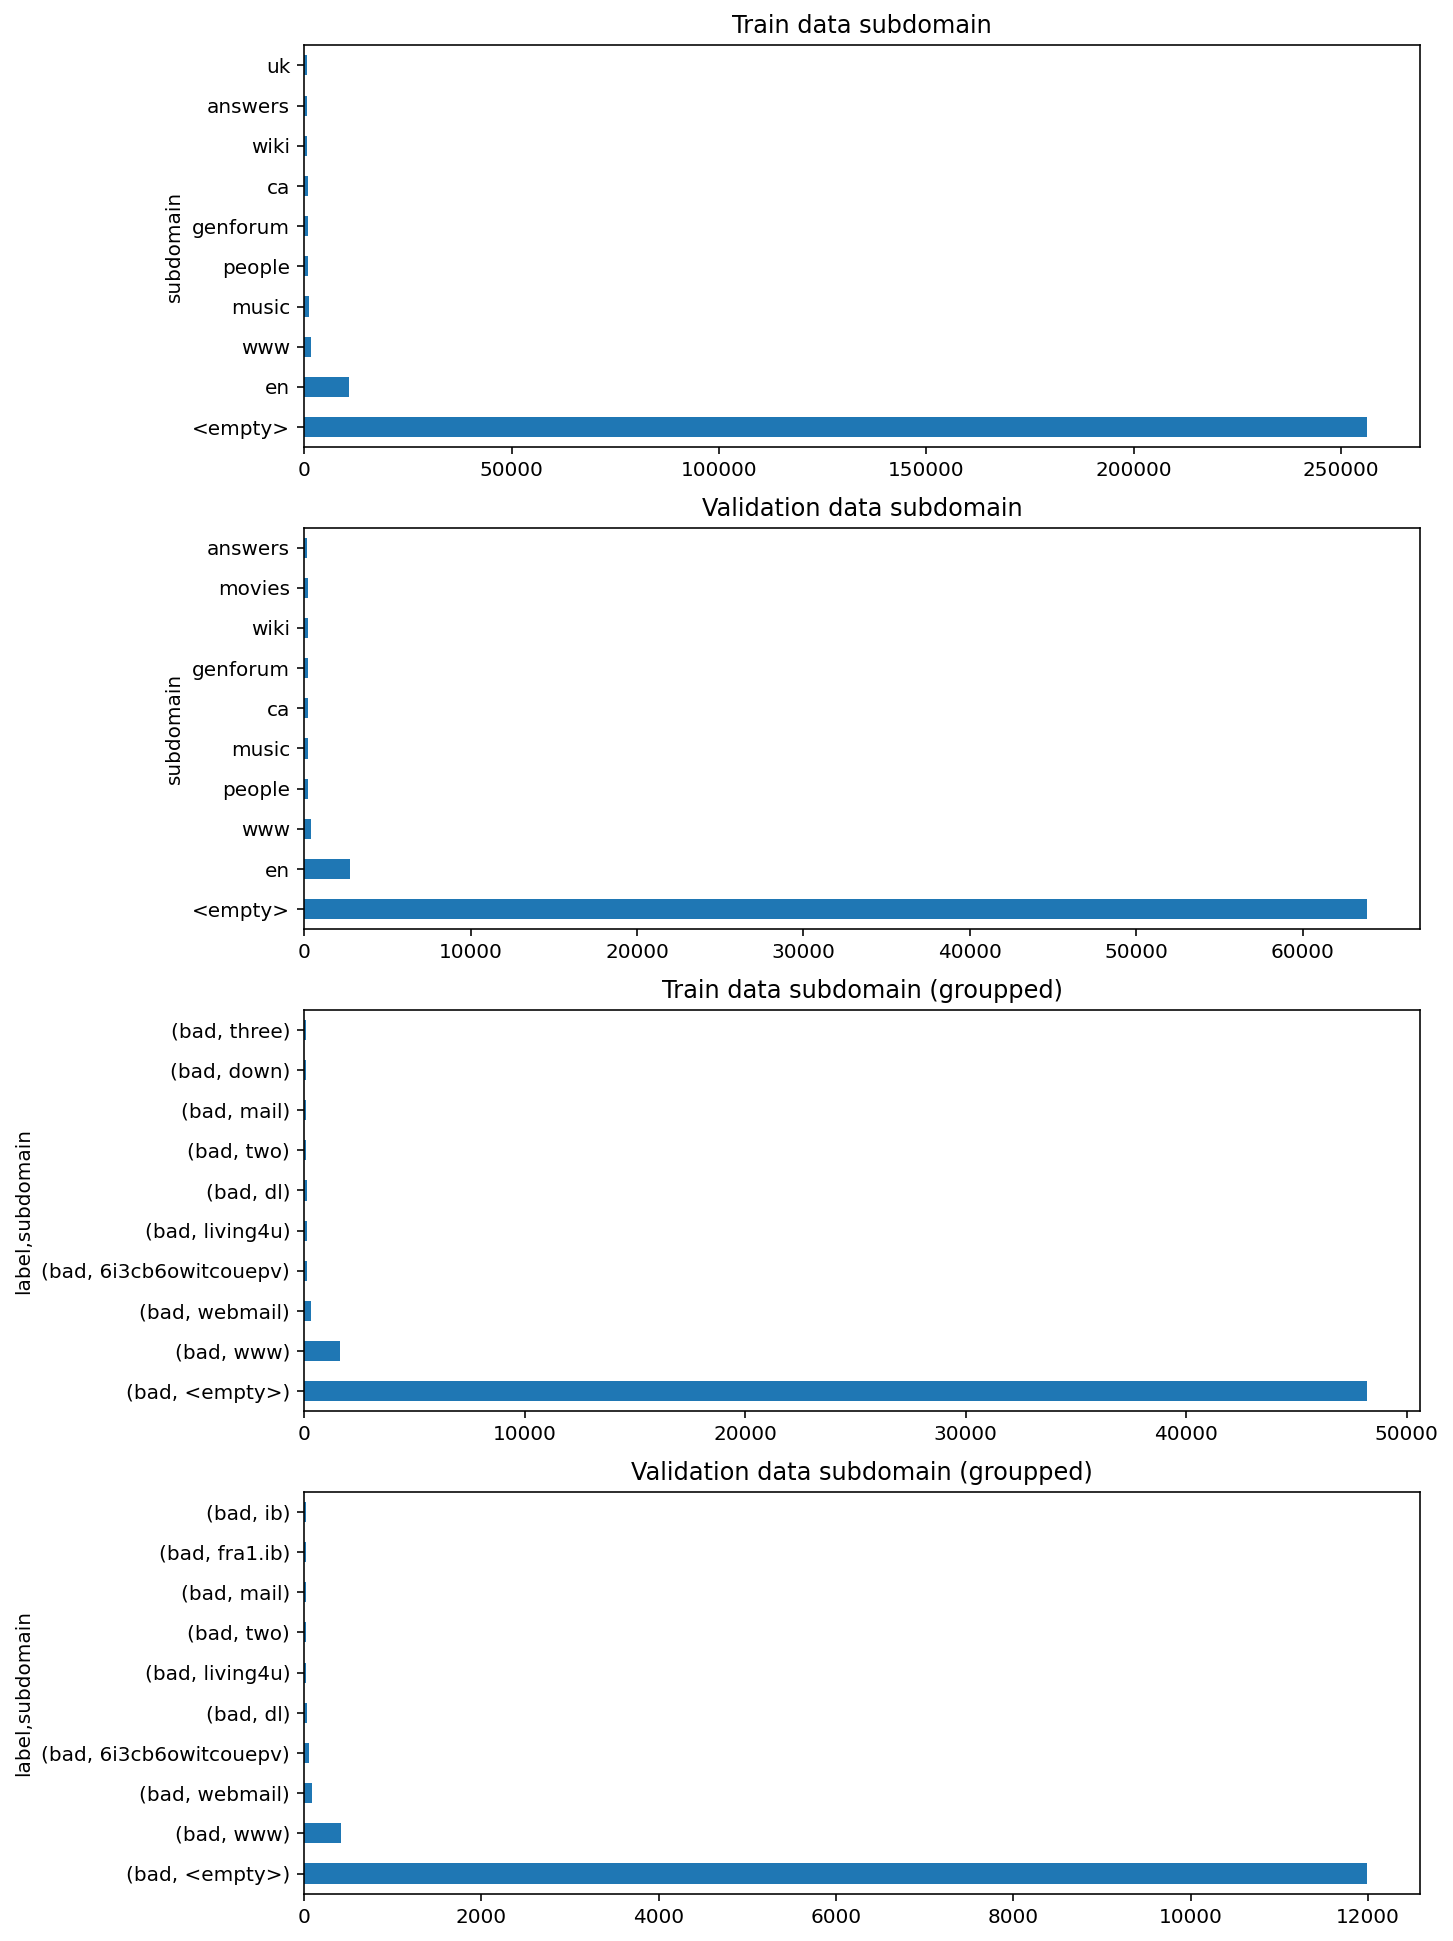

In [15]:
plot(train_data, val_data, 'subdomain')

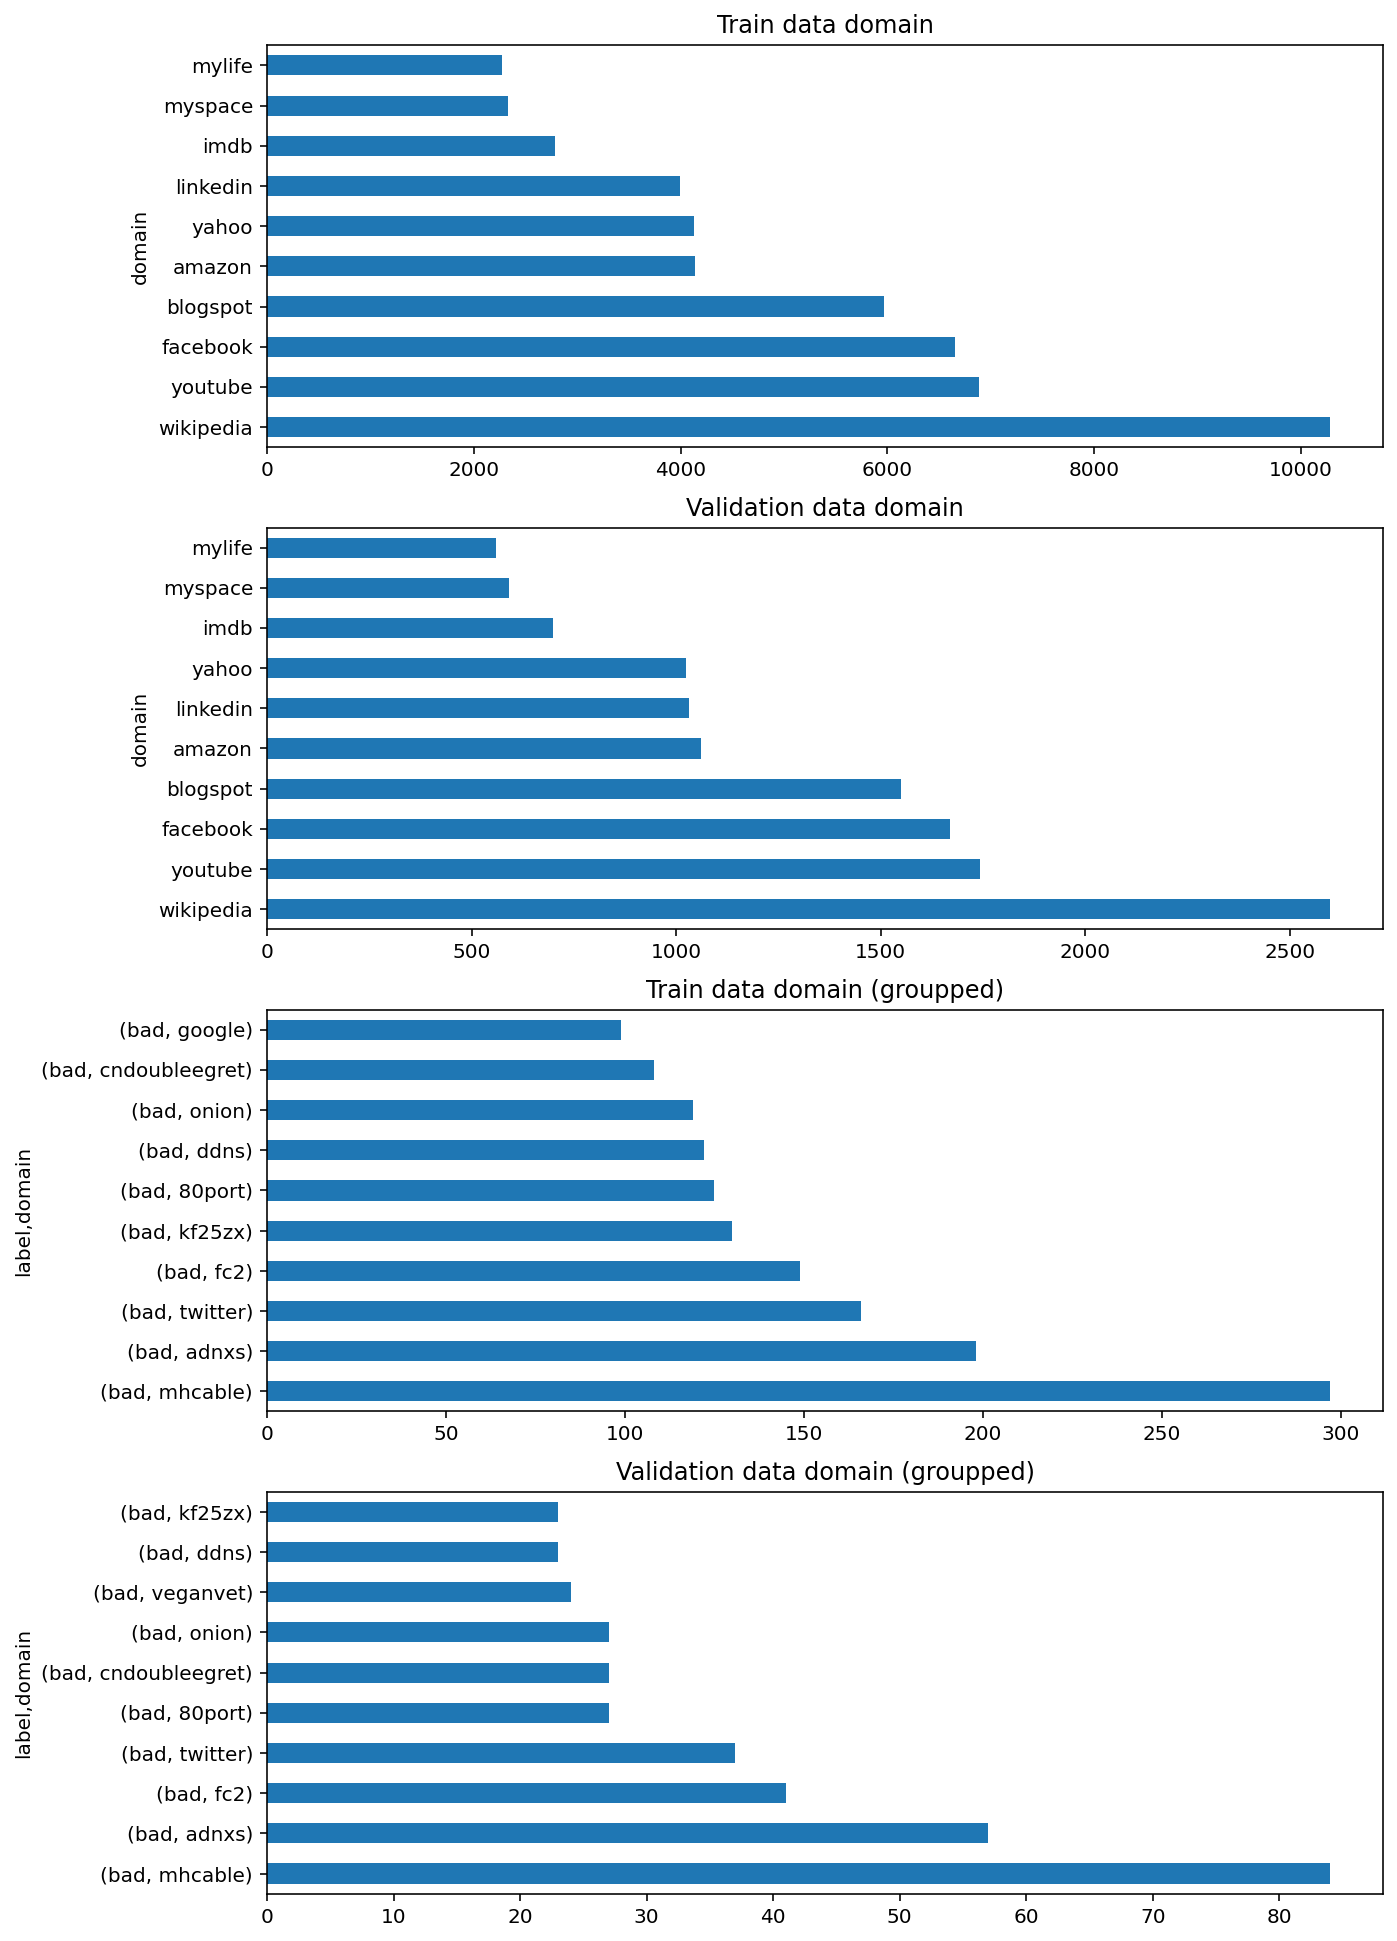

In [16]:
plot(train_data, val_data, 'domain')

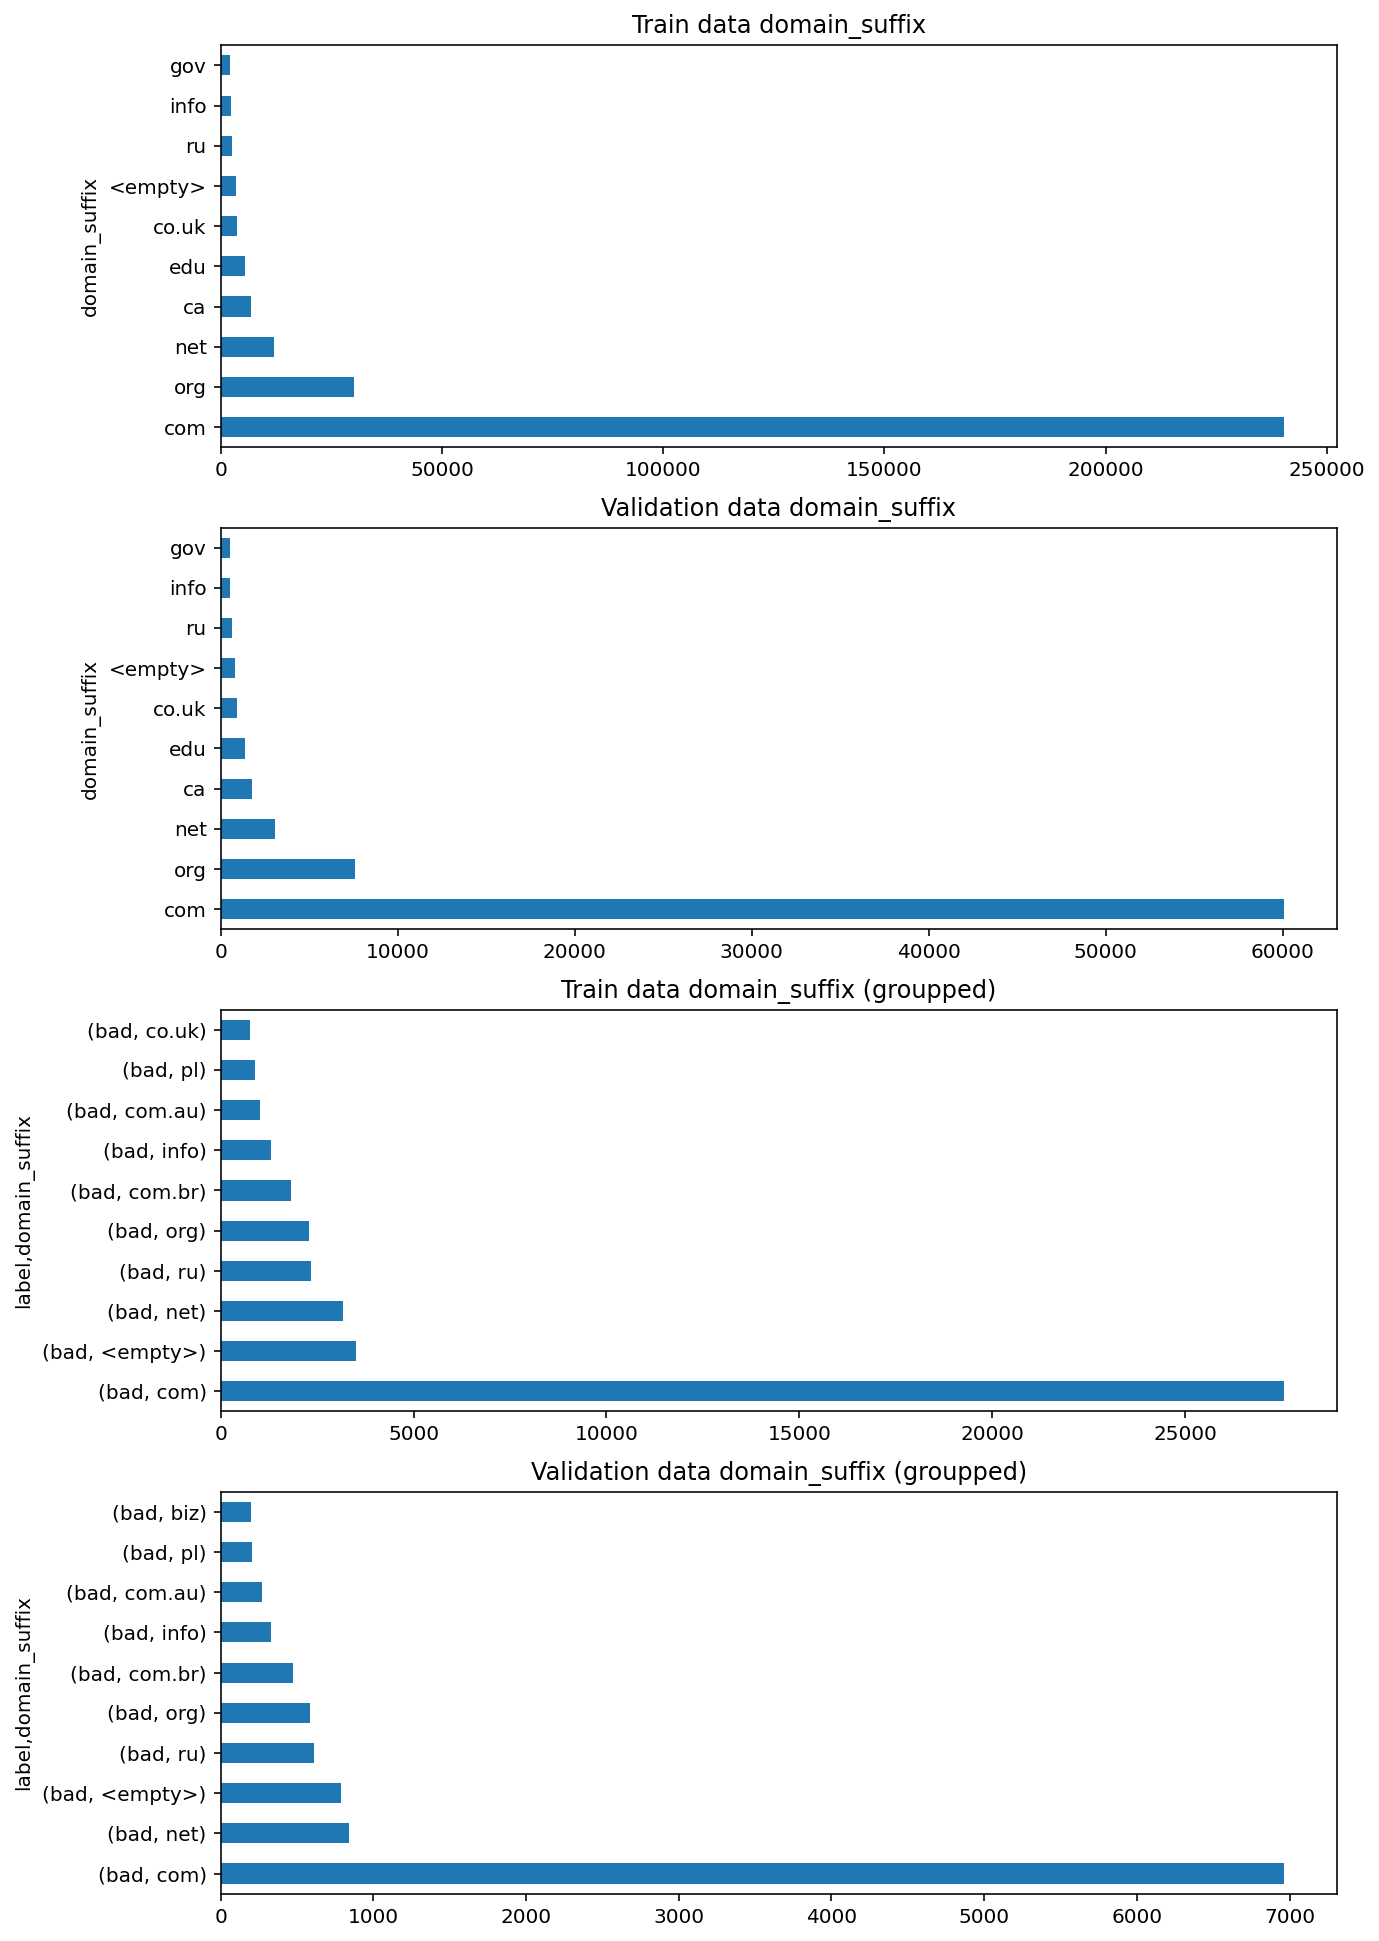

In [17]:
plot(train_data, val_data, 'domain_suffix')

Based on the plot above there are interesting things to note, there are websites that have google and twitter domains with bad labels. It's time we do the filter to see data with google domains and Twitter with bad labels

In [18]:
train_data[(train_data['domain'] == 'google') & (train_data['label'] == 'bad')].head()

,url,label,subdomain,domain,domain_suffix
25,drive.google.com/uc?export=download&amp;id=0B7XzN8DNbJKiQlFNRHdVTmpCd0U,bad,drive,google,com
1571,accounts.google.com/ServiceLogin?continue=https://drive.google.com/st/auth/host/0Bz9pzRUAjfXaT3RXengxQXV3dlU/,bad,accounts,google,com
6633,docs.google.com/document/d/1OKcZKiBvp-c9kOeo9A0ODVkbAxmzpfcZGFW_jf6CbRM/pub,bad,docs,google,com
8390,docs.google.com/document/d/1-1buo7hGcqSRbCeoJ4OtbQkk0JjzkPEHULycAxHAbd0/pub,bad,docs,google,com
9236,"https://plus.google.com/share?title=FerienWohnung%20in%20centro%20a%20Mantova|Italien,%20Mantova,%20Mantova|trans&amp;url=http://b.ems.to/YRR.:boeZ:t7m6q",bad,plus,google,com


In [19]:
train_data[(train_data['domain'] == 'twitter') & (train_data['label'] == 'bad')].head()

,url,label,subdomain,domain,domain_suffix
697,twitter.com/CjreLwzL,bad,<empty>,twitter,com
703,twitter.com/QAwADQA,bad,<empty>,twitter,com
2378,twitter.com/bvXPoAH,bad,<empty>,twitter,com
2786,twitter.com/D99oXj1p4sm,bad,<empty>,twitter,com
2886,twitter.com/wAtADEAMAA,bad,<empty>,twitter,com


Maybe some of there urls contain malware, who knows :) <br>
The next step we need to do tokenization on the url so that it can be used as input to the CNN model

In [20]:
tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)
# fit only on training data
tokenizer.fit_on_texts(train_data['url'])
n_char = len(tokenizer.word_index.keys())
print(f'N Char: {n_char}')

N Char: 177


In [21]:
train_seq = tokenizer.texts_to_sequences(train_data['url'])
val_seq = tokenizer.texts_to_sequences(val_data['url'])
print('Before tokenization: ')
print(train_data.iloc[0]['url'])
print('\nAfter tokenization: ')
print(train_seq[0])

Before tokenization: 
melangemagazine.com/wp-content/plugins/telekom/vodafone_onlinerechnung

After tokenization: 
[12, 2, 14, 4, 11, 20, 2, 12, 4, 20, 4, 43, 5, 11, 2, 13, 8, 3, 12, 6, 26, 17, 15, 8, 3, 11, 7, 2, 11, 7, 6, 17, 14, 19, 20, 5, 11, 9, 6, 7, 2, 14, 2, 28, 3, 12, 6, 30, 3, 16, 4, 25, 3, 11, 2, 29, 3, 11, 14, 5, 11, 2, 10, 2, 8, 18, 11, 19, 11, 20]


In [22]:
sequence_length = np.array([len(i) for i in train_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Sequence length: {sequence_length}')

Sequence length: 162


Each text length has a different length, therefore padding is needed to equalize each text length

In [24]:
train_seq = pad_sequences(train_seq, padding='post', maxlen=sequence_length)
val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)#162
print('After padding: ')
print(train_seq[0])

After padding: 
[12  2 14  4 11 20  2 12  4 20  4 43  5 11  2 13  8  3 12  6 26 17 15  8
  3 11  7  2 11  7  6 17 14 19 20  5 11  9  6  7  2 14  2 28  3 12  6 30
  3 16  4 25  3 11  2 29  3 11 14  5 11  2 10  2  8 18 11 19 11 20  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


The next step is to normalize so the value has a scale between 0 and 1

In [25]:
train_seq = train_seq / n_char # 177
val_seq = val_seq / n_char

save the tokenizer for later use

In [26]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Encoding Features

We will also encode subdomain, domain, suffix domains and label into numerical variables

In [27]:
def encode_label(label_index, data):
    try:
        return label_index[data]
    except:
        return label_index['<unknown>']

In [28]:
unique_value = {}
for feature in ['subdomain', 'domain', 'domain_suffix']:
    # get unique value
    label_index = {label: index for index, label in enumerate(train_data[feature].unique())}
    # add unknown label in last index
    label_index['<unknown>'] = list(label_index.values())[-1] + 1
    # count unique value
    unique_value[feature] = label_index['<unknown>']
    # encode
    train_data.loc[:, feature] = [encode_label(label_index, i) for i in train_data.loc[:, feature]]
    val_data.loc[:, feature] = [encode_label(label_index, i) for i in val_data.loc[:, feature]]
    # save label index
    with open(f'{feature}.pkl', 'wb') as f:
        pickle.dump(label_index, f)

In [29]:
for data in [train_data, val_data]:
    data.loc[:, 'label'] = [0 if i == 'good' else 1 for i in data.loc[:, 'label']]

In [30]:
print(f"Unique subdomain in Train data: {unique_value['subdomain']}")
print(f"Unique domain in Train data: {unique_value['domain']}")
print(f"Unique domain suffix in Train data: {unique_value['domain_suffix']}")

Unique subdomain in Train data: 23345
Unique domain in Train data: 98290
Unique domain suffix in Train data: 673


# Create CNN Model

In [31]:
def convolution_block(x):
    # 3 sequence conv layer
    conv_3_layer = layers.Conv1D(64, 3, padding='same', activation='elu')(x)
    # 5 sequence conv layer
    conv_5_layer = layers.Conv1D(64, 5, padding='same', activation='elu')(x)
    # concat conv layer
    conv_layer = layers.concatenate([x, conv_3_layer, conv_5_layer])
    # flatten
    conv_layer = layers.Flatten()(conv_layer)
    return conv_layer

In [32]:
def embedding_block(unique_value, size):
    input_layer = layers.Input(shape=(1,))
    embedding_layer = layers.Embedding(unique_value, size, input_length=1)(input_layer)
    return input_layer, embedding_layer

In [33]:
def create_model(sequence_length, n_char, n_subdomain, n_domain, n_domain_suffix):
    input_layer = []
    # sequence input layer
    sequence_input_layer = layers.Input(shape=(sequence_length,))
    input_layer.append(sequence_input_layer)
    # convolution block
    char_embedding = layers.Embedding(n_char + 1, 32, input_length=sequence_length)(sequence_input_layer)
    conv_layer = convolution_block(char_embedding)
    # entity embedding
    entity_embedding = []
    for n in [n_subdomain, n_domain, n_domain_suffix]:
        size = 4
        input_l, embedding_l = embedding_block(n, size)
        embedding_l = layers.Reshape(target_shape=(size,))(embedding_l)
        input_layer.append(input_l)
        entity_embedding.append(embedding_l)
    # concat all layer
    fc_layer = layers.concatenate([conv_layer, *entity_embedding])
    fc_layer = layers.Dropout(rate=0.5)(fc_layer)
    # dense layer
    fc_layer = layers.Dense(128, activation='elu')(fc_layer)
    fc_layer = layers.Dropout(rate=0.2)(fc_layer)
    # output layer
    output_layer = layers.Dense(1, activation='sigmoid')(fc_layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(), metrics.Recall()])
    return model

In [34]:
# reset session
backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
random.seed(0)
#tf.set_random_seed(0)
# create model
model = create_model(sequence_length, n_char, unique_value['subdomain'], unique_value['domain'], unique_value['domain_suffix'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 162)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 162, 32)      5696        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 162, 64)      6208        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 162, 64)      10304       embedding[0][0]                  
______________________________________________________________________________________________

In [35]:
"""plot_model(model, to_file='model.png')
model_image = mpimg.imread('model.png')
plt.figure(figsize=(75, 75))
plt.imshow(model_image)
plt.show()"""

"plot_model(model, to_file='model.png')\nmodel_image = mpimg.imread('model.png')\nplt.figure(figsize=(75, 75))\nplt.imshow(model_image)\nplt.show()"


The above has 4 encoded inputs: 
1. the first input came from URL that has been done tokenization and padding. 
2. subdomains, 
3. domains, and 
4. suffix domains
 
URL input will pass through embedding layer and convolution layer while other input will pass embedding layer. Then the results from each input will be concatenated.

# Model Training

In [ ]:
"""
From this cell, there are too many errors
"""

In [36]:
train_x = [train_seq, train_data['subdomain'], train_data['domain'], train_data['domain_suffix']]
train_y = train_data['label']
val_x = [val_seq, val_data['subdomain'], val_data['domain'], val_data['domain_suffix']]
val_y = val_data['label']

In [37]:
early_stopping = [EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True, mode='max')]
history = model.fit(train_x, train_y, batch_size=64, epochs=25, verbose=1, validation_data=[val_x, val_y], shuffle=True, callbacks=early_stopping)
model.save('model.h5')

Epoch 1/25
5256/5256 [==============================] - ETA: 0s - loss: 0.2506 - precision: 0.8385 - recall: 0.5345

ValueError: in user code:

    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1323 test_function  *
        return step_function(self, iterator)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1314 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1307 run_step  **
        outputs = model.test_step(data)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1266 test_step
        y_pred = self(x, training=False)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/apple/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:200 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model expects 4 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 162) dtype=float32>, <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int64>, <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=int64>]


NameError: name 'history' is not defined

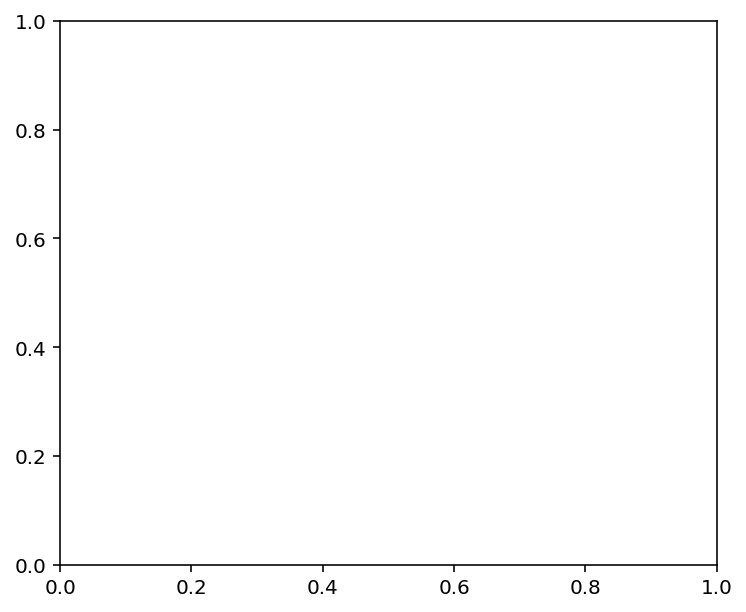

In [38]:
plt.figure(figsize=(20, 5))
for index, key in enumerate(['loss', 'precision', 'recall']):
    plt.subplot(1, 3, index+1)
    plt.plot(history.history[key], label=key)
    plt.plot(history.history[f'val_{key}'], label=f'val {key}')
    plt.legend()
    plt.title(f'{key} vs val {key}')
    plt.ylabel(f'{key}')
    plt.xlabel('epoch')

# Model Validation

In [39]:
val_pred = model.predict(val_x)
val_pred = np.where(val_pred[:, 0] >= 0.5, 1, 0)
print(f'Validation Data:\n{val_data.label.value_counts()}')
print(f'\n\nConfusion Matrix:\n{confusion_matrix(val_y, val_pred)}')
print(f'\n\nClassification Report:\n{classification_report(val_y, val_pred)}')

InvalidArgumentError:  indices[12,0] = 23345 is not in [0, 23345)
	 [[node model/embedding_1/embedding_lookup (defined at <ipython-input-39-2a72bd9d0c12>:1) ]] [Op:__inference_predict_function_18099]

Errors may have originated from an input operation.
Input Source operations connected to node model/embedding_1/embedding_lookup:
 model/embedding_1/embedding_lookup/18045 (defined at /opt/anaconda3/lib/python3.8/contextlib.py:113)

Function call stack:
predict_function


# Questions

1. What is the precision of this mode? 
2. What is the recall of this mode?
3. What is the relationship between high precision value and the classified malicious websites? 
4. What is the relationship between low precision value and the classified malicious websites? 